In [ ]:
!wget https://www.statmt.org/europarl/v7/ro-en.tgz
!tar -xf ro-en.tgz
!pip install transformers
!pip install SentencePiece
!pip install nltk bert-score

--2024-05-03 16:26:50--  https://www.statmt.org/europarl/v7/ro-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.32.28
Connecting to www.statmt.org (www.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38180223 (36M) [application/x-gzip]
Saving to: ‘ro-en.tgz’

ro-en.tgz           100%[===================>]  36.41M  9.16MB/s    in 4.0s    

2024-05-03 16:26:55 (9.16 MB/s) - ‘ro-en.tgz’ saved [38180223/38180223]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using c

In [ ]:
import os
import re
import random
import string
import pickle
import unicodedata
import numpy as np
import pandas as pd
from io import open
from tqdm import tqdm
from pickle import dump
import matplotlib.pyplot as plt
from unicodedata import normalize

In [ ]:
import nltk
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from sklearn.model_selection import train_test_split
from torch import optim
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from torchtext.data.metrics import bleu_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cuda


In [ ]:
def read_file(file_name):
    with open(file_name, mode='rt', encoding='utf-8') as file:
        return file.read()

def process_sentences(text):
    sentences = text.strip().split('\n')
    regex_statement = re.compile('[^%s]' % re.escape(string.printable))
    translation_table = str.maketrans('', '', string.punctuation)

    filtered_sentences = []
    for line in sentences:
        line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
        words = [word.lower().translate(translation_table) for word in line.split()]
        words = [regex_statement.sub('', word) for word in words if word.isalpha()]
        filtered_sentences.append(' '.join(words))

    return filtered_sentences

def save_processed_sentences(filtered_sentences, output_filename):
    with open(output_filename, 'wb') as file:
        pickle.dump(filtered_sentences, file)

def process_input_text(file_name, output_filename):
    text = read_file(file_name)
    filtered_sentences = process_sentences(text)
    save_processed_sentences(filtered_sentences, output_filename)
    return filtered_sentences

filtered_sentences1 = process_input_text('europarl-v7.ro-en.en', 'english.pkl')
print("Saved English sentences to english.pkl file")

filtered_sentences2 = process_input_text('europarl-v7.ro-en.ro', 'romanian.pkl')
print("Saved Romanian sentences to romanian.pkl file")

Saved English sentences to english.pkl file
Saved Romanian sentences to romanian.pkl file


In [ ]:
def load_data(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

romanian_file = 'romanian.pkl'
english_file = 'english.pkl'

romanian_data = load_data(romanian_file)
english_data = load_data(english_file)

subset_size = 120000
romanian_subset = romanian_data[:subset_size]
english_subset = english_data[:subset_size]

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
tokenized_data = {'input_ids': [], 'attention_mask': [], 'labels': []}

for ro, en in zip(romanian_subset, english_subset):
    if isinstance(ro, str) and isinstance(en, str):
        tokenized_romanian_data = tokenizer(ro, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        tokenized_english_data = tokenizer(en, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

        tokenized_data['input_ids'].append(tokenized_romanian_data.input_ids)
        tokenized_data['attention_mask'].append(tokenized_romanian_data.attention_mask)
        tokenized_data['labels'].append(tokenized_english_data.input_ids)

data_tuples = list(zip(tokenized_data['input_ids'], tokenized_data['attention_mask'], tokenized_data['labels']))
training_tuples, validation_tuples = train_test_split(data_tuples, test_size=0.2)

class TranslationDataset(Dataset):
    def __init__(self, data_tuples):
        self.data_tuples = data_tuples

    def __len__(self):
        return len(self.data_tuples)

    def __getitem__(self, index):
        input_ids, attention_mask, labels = self.data_tuples[index]
        return {
            'input_ids': input_ids.squeeze(),
            'attention_mask': attention_mask.squeeze(),
            'labels': labels.squeeze()
        }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
training_dataset = TranslationDataset(training_tuples)
validation_dataset = TranslationDataset(validation_tuples)
training_dataloader = DataLoader(training_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def train(model, training_dataloader, validation_dataloader, optimizer, device):
    model.train()
    total_training_loss = 0

    for batch in training_dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()
    total_validation_loss = 0

    with torch.no_grad():
        for batch in validation_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_validation_loss += loss.item()

    return total_training_loss / len(training_dataloader), total_validation_loss / len(validation_dataloader)

In [11]:
number_of_epochs = 3
plot_training_losses = []
plot_validation_losses = []

for epoch in range(number_of_epochs):
    plot_training_loss, plot_validation_loss = train(model, training_dataloader, validation_dataloader, optimizer, device)
    plot_training_losses.append(plot_training_loss)
    plot_validation_losses.append(plot_validation_loss)
    print(f"Epoch {epoch+1}/{number_of_epochs}, Training Loss: {plot_training_loss}, Validation Loss: {plot_validation_loss}")

Epoch 1/3, Training Loss: 0.17046306789573282, Validation Loss: 0.08844130631101628
Epoch 2/3, Training Loss: 0.09463785111779968, Validation Loss: 0.07390183004705857
Epoch 3/3, Training Loss: 0.08290924238056566, Validation Loss: 0.06872496290970594


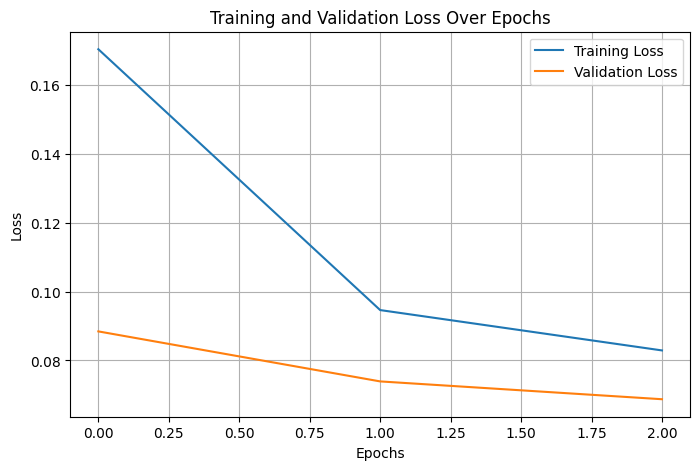

In [12]:
def show_combined_plot(training_losses, validation_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

show_combined_plot(plot_training_losses, plot_validation_losses)

In [13]:
# Save model state dictionary
torch.save(model.state_dict(), 'T5-small.pth')

# Save entire model (not recommended)
with open('T5-small.pkl', 'wb') as file:
    pickle.dump(model, file)

In [14]:
def evaluate_random_samples(model, dataloader, tokenizer, device, number_of_samples=5, max_length=50):
    model.eval()
    sample_count = 0

    for batch in dataloader:
        if sample_count >= number_of_samples:
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Ensure batch dimension is present
        if input_ids.ndim == 1:
            input_ids = input_ids.unsqueeze(0)
        if attention_mask.ndim == 1:
            attention_mask = attention_mask.unsqueeze(0)
        if labels.ndim == 1:
            labels = labels.unsqueeze(0)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length)

        for i in range(input_ids.size(0)):
            if sample_count >= number_of_samples:
                return

            decoded_input_sentences = tokenizer.decode(input_ids[i], skip_special_tokens=True)
            decoded_predicted_sentences = tokenizer.decode(outputs[i], skip_special_tokens=True)
            decoded_expected_sentences = tokenizer.decode(labels[i], skip_special_tokens=True)

            print(f"Romanian: {decoded_input_sentences}\nEnglish (Expected): {decoded_expected_sentences}\nEnglish (Predicted): {decoded_predicted_sentences}\n")
            sample_count += 1

evaluate_random_samples(model, validation_dataloader, tokenizer, device, max_length=50)

Romanian: este datoria noastra fundamentala sa punem in aplicare intrun mod adecvat uniform si eficient acest tratat pentru care am platit un pret atat de mare
English (Expected): it is our fundamental duty to implement smoothly seamlessly and efficiently this treaty which we have paid so dearly for
English (Predicted): it is our fundamental duty to implement this treaty in a proper uniform and effective manner for which we have paid so much

Romanian: intarirea legaturii uebrazilia poate crea un cadru comun prin intermediul caruia cele doua entitati sa se poata dezvolta contribuind astfel la cresterea cooperarii dintre cele doua regiuni
English (Expected): strengthening eubrazil ties may create a common framework which will facilitate the development of these two entities thereby contributing to an increase in cooperation between the two regions
English (Predicted): strengthening eubrazilias links can create a common framework through which the two entities can develop thus contributi

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
def translation_metrics_evaluation(model, dataloader, tokenizer, device):
    model.eval()
    expected_sentences_array = []
    target_sentences_array = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
              outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)

        for i in range(input_ids.size(0)):
            decoded_expected = tokenizer.decode(labels[i], skip_special_tokens=True, truncation=True)
            decoded_target = tokenizer.decode(outputs[i], skip_special_tokens=True, truncation=True)

            if decoded_expected and decoded_target:
                expected_sentences_array.append([decoded_expected.split()])
                target_sentences_array.append(decoded_target.split())

    bleu_score = corpus_bleu(expected_sentences_array, target_sentences_array)

    meteor_scores = [meteor_score(esa, tsa) for esa, tsa in zip(expected_sentences_array, target_sentences_array)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)

    esas = [' '.join(esa[0]) for esa in expected_sentences_array]
    tsas = [' '.join(tsa) for tsa in target_sentences_array]
    P, R, F1 = bert_score(tsas, esas, lang="en", verbose=True)

    F1 = F1.mean().item()
    precision = P.mean().item()
    recall = R.mean().item()

    return bleu_score, average_meteor_score, F1, precision, recall

bleu_score, Meteor_score, F1_score, precision, recall = translation_metrics_evaluation(model, validation_dataloader, tokenizer, device)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/712 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/371 [00:00<?, ?it/s]

done in 64.77 seconds, 366.14 sentences/sec


In [17]:
print(f"BLEU Score: {(bleu_score * 100):.4f}")
print(f"METEOR Score: {(Meteor_score * 100):.4f}")
print(f"F1 Score: {(F1_score * 100):.4f}")
print(f"Precision: {(precision * 100):.4f}")
print(f"Recall: {(recall * 100):.4f}")

BLEU Score: 20.2315
METEOR Score: 48.7152
F1 Score: 92.0291
Precision: 93.3286
Recall: 90.8123
